# Size sorts and p-hacking

In this chapter, we continue with portfolio sorts in a univariate setting. Yet, we consider firm size as a sorting variable, which gives rise to a well-known return factor: the size premium. The size premium arises from buying small stocks and selling large stocks. Prominently, @Fama1993 include it as a factor in their three-factor model. Apart from that, asset managers commonly include size as a key firm characteristic when making investment decisions.

We also introduce new choices in the formation of portfolios. In particular, we discuss listing exchanges, industries, weighting regimes, and periods. These choices matter for the portfolio returns and result in different size premiums [see [Walter2022]( https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4164117) for more insights into decision nodes and their effect on premiums]. Exploiting these ideas to generate favorable results is called p-hacking. 
There is arguably a thin line between p-hacking and conducting robustness tests, our purpose here is simply to illustrate the substantial variation which can arise along the evidence generating process.

In [2]:
import pandas as pd
import sqlite3
tidy_finance = sqlite3.connect("D:/Tidy/tidyfinance.sqlite")
crsp_monthly = pd.read_sql_query("SELECT * from crsp_monthly", tidy_finance)
factors_ff_monthly = pd.read_sql_query("SELECT * from factors_ff_monthly", tidy_finance)

In [3]:
crsp_monthly['month']=pd.to_datetime(crsp_monthly['month'])

## Size distribution

Before we build our size portfolios, we investigate the distribution of the variable *firm size*. Visualizing the data is a valuable starting point to understand the input to the analysis. The figure below shows the fraction of total market capitalization concentrated in the largest firm. To produce this graph, we create monthly indicators that track whether a stock belongs to the largest x% of the firms. 
Then, we aggregate the firms within each bucket and compute the buckets' share of total market capitalization. 

The figure shows that the largest 1% of firms cover up to 50% of the total market capitalization, and holding just the 25% largest firms in the CRSP universe essentially replicates the market portfolio. The distribution of firm size thus implies that the largest firms of the market dominate many small firms whenever we use value-weighted benchmarks.

In [4]:
import numpy as np
crsp_monthly_q01=crsp_monthly.groupby('month').mktcap.quantile(0.99).rename('q01').reset_index()
crsp_monthly_q05=crsp_monthly.groupby('month').mktcap.quantile(0.95).rename('q05').reset_index()
crsp_monthly_q10=crsp_monthly.groupby('month').mktcap.quantile(0.9).rename('q10').reset_index()
crsp_monthly_q25=crsp_monthly.groupby('month').mktcap.quantile(0.75).rename('q25').reset_index()
crsp_monthly_total=crsp_monthly.groupby('month').mktcap.sum().rename('total').reset_index()

In [5]:
crsp_monthly_q=crsp_monthly_q01.merge(crsp_monthly_q05,left_on=['month'],right_on=['month']).merge(crsp_monthly_q10,left_on=['month'],right_on=['month']).merge(crsp_monthly_q25,left_on=['month'],right_on=['month']).merge(crsp_monthly_total,left_on=['month'],right_on=['month'])

In [6]:
crsp_monthly_q=pd.merge(crsp_monthly,crsp_monthly_q,left_on=['month'],right_on=['month'])

In [7]:
crsp_monthly_q['top01']=np.where(crsp_monthly_q['mktcap'] > crsp_monthly_q['q01'], 1, 0)
crsp_monthly_q['top05']=np.where(crsp_monthly_q['mktcap'] > crsp_monthly_q['q05'], 1, 0)
crsp_monthly_q['top10']=np.where(crsp_monthly_q['mktcap'] > crsp_monthly_q['q10'], 1, 0)
crsp_monthly_q['top25']=np.where(crsp_monthly_q['mktcap'] > crsp_monthly_q['q25'], 1, 0)

In [8]:
crsp_monthly_t01=crsp_monthly_q.groupby('month').apply(lambda x: (x.top01 * x.mktcap).sum()/ (x.total.mean())).rename('t01').reset_index()
crsp_monthly_t05=crsp_monthly_q.groupby('month').apply(lambda x: (x.top05 * x.mktcap).sum()/ (x.total.mean())).rename('t05').reset_index()
crsp_monthly_t10=crsp_monthly_q.groupby('month').apply(lambda x: (x.top10 * x.mktcap).sum()/ (x.total.mean())).rename('t10').reset_index()
crsp_monthly_t25=crsp_monthly_q.groupby('month').apply(lambda x: (x.top25 * x.mktcap).sum()/ (x.total.mean())).rename('t25').reset_index()
crsp_monthly_t=crsp_monthly_t01.merge(crsp_monthly_t05,left_on=['month'],right_on=['month']).merge(crsp_monthly_t10,left_on=['month'],right_on=['month']).merge(crsp_monthly_t25,left_on=['month'],right_on=['month'])

In [9]:
crsp_monthly_t=crsp_monthly_t.set_index('month').stack().rename('per').reset_index()
crsp_monthly_t=crsp_monthly_t.rename(columns={'level_1':'t'})

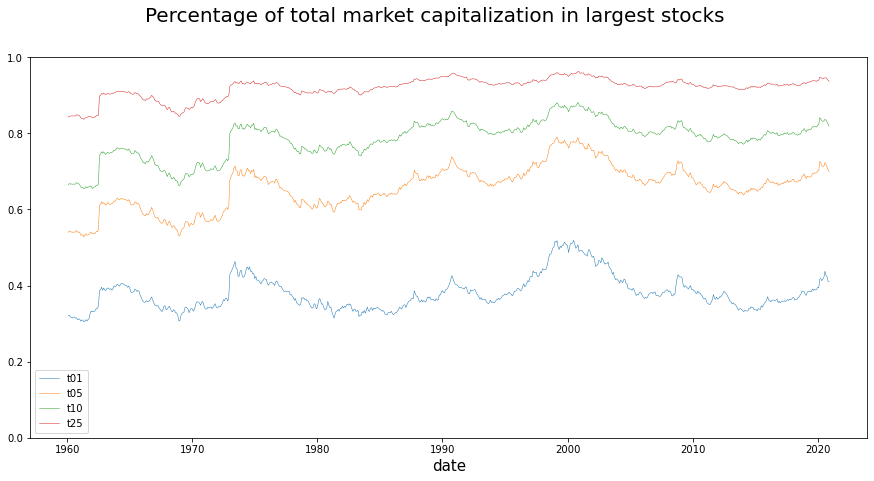

In [10]:
import matplotlib.pyplot as plt
t=list(crsp_monthly_t.t.drop_duplicates())
fig, ax = plt.subplots(figsize = (15,7))
for ind in t:
    ax.plot(crsp_monthly_t[ crsp_monthly_t["t"] == ind ]['month'], crsp_monthly_t[ crsp_monthly_t["t"] == ind ]['per'], linewidth=0.5,label=ind)
fig.suptitle('Percentage of total market capitalization in largest stocks',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.legend()
ax.set_ylim(0,1)
plt.show()

Next, firm sizes also differ across listing exchanges. Stocks' primary listings were important in the past and are potentially still relevant today. The graph below shows that the New York Stock Exchange (NYSE) was and still is the largest listing exchange in terms of market capitalization. More recently, NASDAQ has gained relevance as a listing exchange. Do you know what the small peak in NASDAQ's market cap around the year 2000 was?

In [11]:
exchange_per=crsp_monthly_q.groupby(['month','exchange']).apply(lambda x:((x.mktcap)/(x.total)).sum()).rename('percent').reset_index()

In [12]:
ad={'AMEX':exchange_per.set_index(['month','exchange']).unstack().reset_index().fillna(0).percent.AMEX.values,
  'NASDAQ':exchange_per.set_index(['month','exchange']).unstack().reset_index().fillna(0).percent.NASDAQ.values,
  'NYSE':exchange_per.set_index(['month','exchange']).unstack().reset_index().fillna(0).percent.NYSE.values,
  'Other':exchange_per.set_index(['month','exchange']).unstack().reset_index().fillna(0).percent.Other.values,}

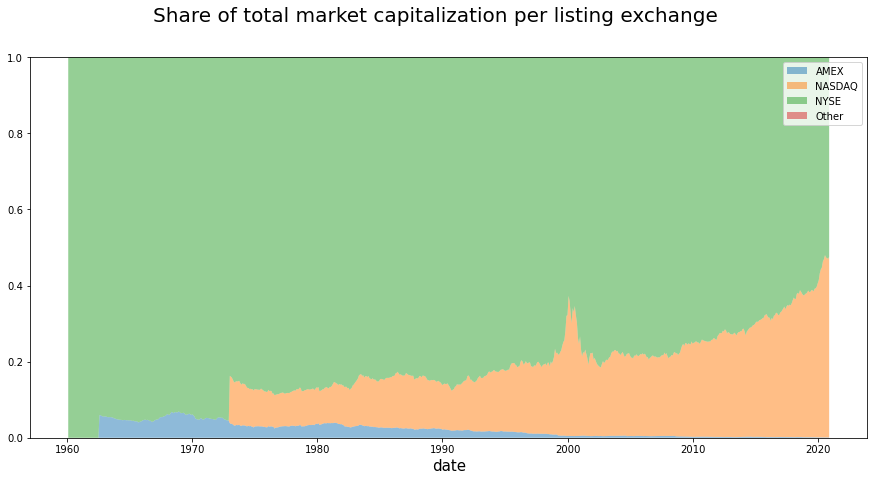

In [13]:
fig, ax = plt.subplots(figsize = (15,7))
ax.stackplot(exchange_per.set_index(['month','exchange']).unstack().reset_index().month, ad.values(), labels=ad.keys(), alpha=0.5)
fig.suptitle('Share of total market capitalization per listing exchange',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.legend()
ax.set_ylim(0,1)
plt.show()

Finally, we consider the distribution of firm size across listing exchanges and create summary statistics. The function summary() does not include all statistics we are interested in, which is why we create the function create_summary() that adds the standard deviation and the number of observations. Then, we apply it to the most current month of our CRSP data on each listing exchange. We also add a row with add_row() with the overall summary statistics.

The resulting table shows that firms listed on NYSE are significantly larger on average than firms listed on the other exchanges. Moreover, NASDAQ lists the largest number of firms. This discrepancy between firm sizes across listing exchanges motivated researchers to form breakpoints exclusively on the NYSE sample and apply those breakpoints to all stocks. In the following, we use this distinction to update our portfolio sort procedure.

In [14]:
crsp_monthly.loc[crsp_monthly.month == crsp_monthly.month.max()].groupby('exchange').mktcap.describe()

,count,mean,std,min,25%,50%,75%,max
exchange,,,,,,,,
AMEX,147.0,282.953956,1297.841498,6.043040,30.722704,65.947860,158.048499,1.514401e+04
NASDAQ,2300.0,8041.183331,74386.213048,4.652530,134.296378,484.829594,2108.447050,2.232279e+06
NYSE,1244.0,16427.132728,43130.344549,5.353300,916.142464,3335.757461,12023.519269,4.143096e+05
Other,1.0,10060.871337,NaN,10060.871337,10060.871337,10060.871337,10060.871337,1.006087e+04


In [15]:
crsp_monthly.loc[crsp_monthly.month == crsp_monthly.month.max()].mktcap.describe()

count    3.692000e+03
mean     1.055843e+04
std      6.397500e+04
min      4.652530e+00
25%      1.848813e+02
50%      8.722199e+02
75%      4.196282e+03
max      2.232279e+06
Name: mktcap, dtype: float64

## Univariate size portfolios with flexible breakpoints

In the previous chapter, we construct portfolios with a varying number of portfolios and different sorting variables. Here, we extend the framework such that we compute breakpoints on a subset of the data, for instance, based on selected listing exchanges. In published asset pricing articles, many scholars compute sorting breakpoints only on NYSE-listed stocks. These NYSE-specific breakpoints are then applied to the entire universe of stocks. 

To replicate the NYSE-centered sorting procedure, we introduce `exchanges` as an argument in our `assign_portfolio()` function. The exchange-specific argument then enters in the filter `.isin(exchange)`. For example, if `exchanges = ['NYSE']` is specified, only stocks from NYSE are used to compute the breakpoints. Alternatively, you could specify `exchanges = ["NYSE", "NASDAQ", "AMEX"]`, which keeps all stocks listed on either of these exchanges. Overall, regular expressions are a powerful tool, and we only touch on a specific case here.

In [16]:
def bucket(row,groups):
    if groups == 10:
        if 0<=row['mktcap_lag']<=row['10%']:
            value = 1
        elif row['mktcap_lag']<=row['20%']:
            value=2
        elif row['mktcap_lag']<=row['30%']:
            value=3
        elif row['mktcap_lag']<=row['40%']:
            value=4
        elif row['mktcap_lag']<=row['50%']:
            value=5
        elif row['mktcap_lag']<=row['60%']:
            value=6
        elif row['mktcap_lag']<=row['70%']:
            value=7
        elif row['mktcap_lag']<=row['80%']:
            value=8
        elif row['mktcap_lag']<=row['90%']:
            value=9
        elif row['mktcap_lag']> row['90%']:
            value=10
        else:
            value=''
    if groups == 5:
        if 0<=row['mktcap_lag']<=row['20%']:
            value = 1
        elif row['mktcap_lag']<=row['40%']:
            value=2
        elif row['mktcap_lag']<=row['60%']:
            value=3
        elif row['mktcap_lag']<=row['80%']:
            value=4
        elif row['mktcap_lag']>row['80%']:
            value=5
        else:
            value=''
    if groups == 2:
        if 0<=row['mktcap_lag']<=row['50%']:
            value = 1
        elif row['mktcap_lag']> row['50%']:
            value= 2
    return value

In [17]:
def assign_portfolio(df,exchange,groups):
    nyse = df.loc[df['exchange'].isin(exchange)].groupby(["month"])['mktcap_lag'].describe(percentiles=np.linspace(0,1,groups+1)[1:-1]).reset_index()
    if groups % 2==1:
        nyse=nyse.iloc[:,[0]+list(range(5,5+groups))].merge(df, how='inner', left_on=['month'], right_on = ['month'])
    else:
        nyse=nyse.iloc[:,[0]+list(range(5,5+groups-1))].merge(df, how='inner',left_on=['month'], right_on = ['month'])
    nyse['portfolio']=nyse.apply( lambda x:bucket(x,groups), axis=1)
    return nyse
#exchange must be a list of exchange

## Weighting schemes for portfolios

Apart from computing breakpoints on different samples, researchers often use different portfolio weighting schemes. So far, we weighted each portfolio constituent by its relative market equity of the previous period. This protocol is called *value-weighting*. The alternative protocol is *equal-weighting*, which assigns each stock's return the same weight, i.e., a simple average of the constituents' returns. Notice that equal-weighting is difficult in practice as the portfolio manager needs to rebalance the portfolio monthly while value-weighting is a truly passive investment.

We implement the two weighting schemes in the function `compute_portfolio_returns()` that takes a logical argument to weight the returns by firm value. The statement `if_else(value_weighted, np.average(weights=x['mktcap_lag'])` generates value-weighted returns if `value_weighted = TRUE`. Additionally, the long-short portfolio is long in the smallest firms and short in the largest firms, consistent with research showing that small firms outperform their larger counterparts. Apart from these two changes, the function is similar to the procedure in the previous chapter.

In [18]:
def compute_portfolio_returns(n_portfolios = 10,
                                      exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                      value_weighted = True,
                                      data = crsp_monthly,):
    data = assign_portfolio(data,exchanges,n_portfolios)
    data=data.dropna(subset=['portfolio'])
    if value_weighted == True:
       weight_value=data.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'], weights=x['mktcap_lag'])], 
                                                                index=['value_weighted'])).reset_index()
    else:
        weight_value=data.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'])], 
                                                                index=['value_weighted'])).reset_index()
    weight_value=weight_value.set_index(['month','portfolio']).unstack().reset_index()
    weight_value['size_premium']=weight_value.value_weighted.iloc[: , 0]-weight_value.value_weighted.iloc[: , -1]
    weight_value=weight_value[['month','size_premium']]
    weight_value.columns=['month','size_premium']
    mean_value=weight_value.size_premium.mean()
    return {'n_portfolios': n_portfolios,'value_weighted':value_weighted,'exchange':','.join(exchanges),'Premium':mean_value}

To see how the function `compute_portfolio_returns()` works, we consider a simple median breakpoint example with value-weighted returns. We are interested in the effect of restricting listing exchanges on the estimation of the size premium. In the first function call, we compute returns based on breakpoints from all listing exchanges. Then, we computed returns based on breakpoints from NYSE-listed stocks.

In [19]:
print(compute_portfolio_returns(n_portfolios = 2,
                                      exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                      value_weighted = True,
                                      data = crsp_monthly))
print(compute_portfolio_returns(n_portfolios = 2,
                                      exchanges = ["NYSE"],
                                      value_weighted = True,
                                      data = crsp_monthly))

{'n_portfolios': 2, 'value_weighted': True, 'exchange': 'NYSE,NASDAQ,AMEX', 'Premium': 0.0010949120316526644}
{'n_portfolios': 2, 'value_weighted': True, 'exchange': 'NYSE', 'Premium': 0.0018074063513668103}


The table shows that the size premium is more than 60% larger if we consider only stocks from NYSE to form the breakpoint each month. The NYSE-specific breakpoints are larger, and there are more than 50% of the stocks in the entire universe in the resulting small portfolio because NYSE firms are larger on average. The impact of this choice is not negligible.  


## P-hacking and non-standard errors

Since the choice of the exchange has a significant impact, the next step is to investigate the effect of other data processing decisions researchers have to make along the way. In particular, any portfolio sort analysis has to decide at least on the number of portfolios, the listing exchanges to form breakpoints, and equal- or value-weighting. Further, one may exclude firms that are active in the finance industry or restrict the analysis to some parts of the time series. All of the variations of these choices that we discuss here are part of scholarly articles published in the top finance journals. We refer to @Walter2022 for an extensive set of other decision nodes at the discretion of researchers. 

The intention of this application is to show that the different ways to form portfolios result in different estimated size premiums. Despite the effects of this multitude of choices, there is no correct way. It should also be noted that none of the procedures is wrong, the aim is simply to illustrate the changes that can arise due to the variation in the evidence-generating process [Menkveld2022](https://papers.ssrn.com/sol3/papers.cfm?abstract\%5Fid=3961574).
From a malicious perspective, these modeling choices give the researcher multiple *chances* to find statistically significant results. Yet this is considered *p-hacking*, which renders the statistical inference due to multiple testing invalid [Harvey2016](https://doi.org/10.1093/rfs/hhv059).

Nevertheless, the multitude of options creates a problem since there is no single correct way of sorting portfolios. How should a researcher convince a reader that their results do not come from a p-hacking exercise? To circumvent this dilemma, academics are encouraged to present evidence from different sorting schemes as *robustness tests* and report multiple approaches to show that a result does not depend on a single choice. Thus, the robustness of premiums is a key feature. 

Below we conduct a series of robustness tests which could also be interpreted as a p-hacking exercise. To do so, we examine the size premium in different specifications presented in the table `p_hacking_setup`. The function `itertools.product()` produces a table of all possible permutations of its arguments. Note that we use the argument `params` to exclude financial firms and truncate the time series. 

In [28]:
crsp_monthly_m=crsp_monthly[['month','exchange','ret_excess','mktcap_lag','industry']]
crsp_monthly_m_nof=crsp_monthly_m.loc[crsp_monthly_m.industry != 'Finance']
crsp_monthly_m_m90=crsp_monthly_m.loc[crsp_monthly_m.month < pd.to_datetime('1990-06-01')]
crsp_monthly_m_b90=crsp_monthly_m.loc[crsp_monthly_m.month >= pd.to_datetime('1990-06-01')]

In [29]:
def func(df):
    return df
def func1(df):
    return df.loc[df.industry != 'Finance']
def func2(df):
    return df.loc[df.month < pd.to_datetime('1990-06-01')]
def func3(df):
    return df.loc[df.month >= pd.to_datetime('1990-06-01')]


In [30]:
def compute_portfolio_returns(n_portfolios = 10,
                                      exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                      value_weighted = True,
                                      data = crsp_monthly_m,func=func):
    data = func(data)
    data = assign_portfolio(data,exchanges,n_portfolios)
    data=data.dropna(subset=['portfolio'])
    if value_weighted == True:
       weight_value=data.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'], weights=x['mktcap_lag'])], 
                                                                index=['value_weighted'])).reset_index()
    else:
        weight_value=data.groupby(['month', 'portfolio']).apply(lambda x: pd.Series([np.average(x['ret_excess'])], 
                                                                index=['value_weighted'])).reset_index()
    weight_value=weight_value.set_index(['month','portfolio']).unstack().reset_index()
    weight_value['size_premium']=weight_value.value_weighted.iloc[: , 0]-weight_value.value_weighted.iloc[: , -1]
    weight_value=weight_value[['month','size_premium']]
    weight_value.columns=['month','size_premium']
    mean_value=weight_value.size_premium.mean()
    return {'n_portfolios': n_portfolios,'value_weighted':value_weighted,'exchange':','.join(exchanges),'Premium':mean_value}

In [34]:
params = {
    'n_portfolios': [2, 5, 10],
    'exchanges': [["NYSE"],["NYSE", "NASDAQ", "AMEX"]],
    'value_weighted': [True, False],
    'data':[crsp_monthly_m,crsp_monthly_m_nof,crsp_monthly_m_m90,crsp_monthly_m_b90]
}

In [35]:
import itertools
keys = list(params)

In [36]:
from joblib import Parallel, delayed
import multiprocessing

In [38]:
params = {
    'n_portfolios': [2, 5, 10],
    'exchanges': [["NYSE"],["NYSE", "NASDAQ", "AMEX"]],
    'value_weighted': [True, False],
    'func':[func,func1,func2,func3]
}

In [40]:
Parallel(n_jobs=multiprocessing.cpu_count(), prefer="threads")(delayed(compute_portfolio_returns)(**dict(zip(keys, values))) for values in itertools.product(*map(params.get, keys)))

[{'n_portfolios': 2,
  'value_weighted': True,
  'exchange': 'NYSE',
  'Premium': 0.0018074063513668103},
 {'n_portfolios': 2,
  'value_weighted': True,
  'exchange': 'NYSE',
  'Premium': 0.0018084229654048655},
 {'n_portfolios': 2,
  'value_weighted': True,
  'exchange': 'NYSE',
  'Premium': 0.0021265753031756486},
 {'n_portfolios': 2,
  'value_weighted': True,
  'exchange': 'NYSE',
  'Premium': 0.0014908464100632161},
 {'n_portfolios': 2,
  'value_weighted': False,
  'exchange': 'NYSE',
  'Premium': 0.0023400904154117657},
 {'n_portfolios': 2,
  'value_weighted': False,
  'exchange': 'NYSE',
  'Premium': 0.002585519907311371},
 {'n_portfolios': 2,
  'value_weighted': False,
  'exchange': 'NYSE',
  'Premium': 0.002129184564264201},
 {'n_portfolios': 2,
  'value_weighted': False,
  'exchange': 'NYSE',
  'Premium': 0.002549272240528154},
 {'n_portfolios': 2,
  'value_weighted': True,
  'exchange': 'NYSE,NASDAQ,AMEX',
  'Premium': 0.0010949120316526644},
 {'n_portfolios': 2,
  'value_wei

In [22]:
res=pd.DataFrame()
for values in itertools.product(*map(params.get, keys)):
    temp=compute_portfolio_returns(**dict(zip(keys, values)))
    res=res.append(temp,ignore_index=True)

## The size-premium variation

We provide a graph that shows the different premiums. This plot also shows the relation to the average Fama-French SMB (small minus big) premium used in the literature which we include as a dotted vertical line.

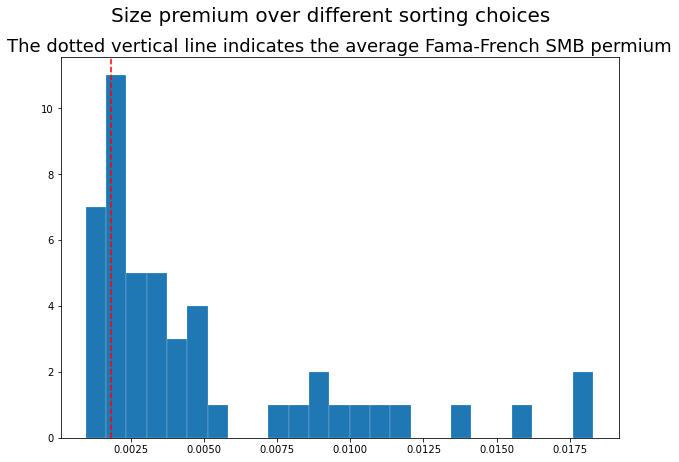

In [23]:
fig, ax = plt.subplots(figsize = (10,7))
ax.hist(res.Premium, bins=25, linewidth=0.2, edgecolor="white")
fig.suptitle('Size premium over different sorting choices',fontsize=20)
ax.set_title("The dotted vertical line indicates the average Fama-French SMB permium",fontsize=18)
plt.axvline(x = factors_ff_monthly['smb'].mean(), color = 'r',linestyle="dashed")